# Problems and the system

In specific problems that we wish to solve with immersed layers, there may
be other data and operators that we would like to cache. We do this with
an *extra cache*, which the user can define, along with a problem type associated
with this cache. The basic cache and the extra cache are generated and associated
together in a *system*.

There are a few basic ingredients to do this:
* **Create a problem type**, using the macro `@ilmproblem`. This mostly just serves as a means of dispatching correctly, but also holds the grid and bodies so they can be passed along when the caches are constructed.
* **Create an extra cache type**, making it a subtype of `AbstractExtraILMCache`. This can hold pretty much anything you want it to.
* **Extend the function `prob_cache(prob,base_cache)`** to serve as a constructor for your extra cache, when your problem type is passed in.

Optionally, you can also extend the function `solve` in order to perform the steps
of your algorithm. However, generically, you can just use pass in the system structure,
which holds the basic ILM cache and your extra cache, into any function.

## Example of problem and system use
We will demonstrate the use of problems and systems with the example
given in A Dirichlet Poisson problem. Here, we will
assemble the various additional data structures and operators used to
solve this problem into an extra cache. We will also create a problem
type called `DirichletPoissonProblem`, which we make a subtype of
`AbstractScalarILMProblem`.

In [1]:
using ImmersedLayers
using Plots
using UnPack

### Create your problem type
For this job, we have a macro

In [2]:
@ilmproblem DirichletPoisson scalar

This generates a type `DirichletPoissonProblem` for dispatch, and an associated
constructor that we'll use later.

### Create your extra cache
Here, we'd like this extra cache to hold the Schur complement and the
filtering matrices, as well as some cache variables.

In [3]:
struct DirichletPoissonCache{SMT,CMT,FRT,ST,FT} <: ImmersedLayers.AbstractExtraILMCache
   S :: SMT
   C :: CMT
   forcing_cache :: FRT
   fb :: ST
   fstar :: FT
end

### Extend the `prob_cache` function
We need this to construct our extra cache. This will get called when the system
is constructed. We can make use of the data available
in the `base_cache` (which is already constructed before this is called)
in order to create the extra cache. (In the example here, we aren't quite ready to
use the `forcing_cache`, so we just keep it blank for now. We will use it later.)

In [4]:
function ImmersedLayers.prob_cache(prob::DirichletPoissonProblem,base_cache::BasicILMCache)
    S = create_RTLinvR(base_cache)
    C = create_surface_filter(base_cache)
    forcing_cache = nothing
    fb = zeros_surface(base_cache)
    fstar = zeros_grid(base_cache)
    DirichletPoissonCache(S,C,forcing_cache,fb,fstar)
end

### Extend the `solve` function
Here, we actually do the work of the algorithm, making use of all of the
operators and data structures that we have cached for efficiency.
The example below takes in some surface Dirichlet data `fbplus`,
and returns the solutions `f` and `s` (filtered).

In [5]:
function ImmersedLayers.solve(fbplus,prob::DirichletPoissonProblem,sys::ILMSystem)
    @unpack extra_cache, base_cache = sys
    @unpack S, C, fb, fstar = extra_cache

    f = zeros_grid(base_cache)
    s = zeros_surface(base_cache)

    surface_divergence!(fstar,fbplus,base_cache)
    fb .= 0.5*fbplus

    inverse_laplacian!(fstar,base_cache)

    interpolate!(s,fstar,base_cache)
    s .= fb - s
    s .= -(S\s);

    regularize!(f,s,base_cache)
    inverse_laplacian!(f,base_cache)
    f .+= fstar;

    s .= C^6*s

    return f, s
end

### Set up the grid, shape, and cache
We do this just as we did in Immersed layer caches, but
now we don't create a cache, since it will be done internally.

In [6]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)
RadC = 1.0
Δs = 1.4*cellsize(g)
body = Circle(RadC,Δs)

Circular body with 448 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Do the work
We do this in three steps:
- Create the problem instance. This is where we use the constructor generated by `@ilmproblem`
- Call `construct_system` to create the caches, assembled into a system
- Call `solve` to solve the problem.
Also, note that pretty much any function that accepts `base_cache`
as an argument also accepts `sys`.

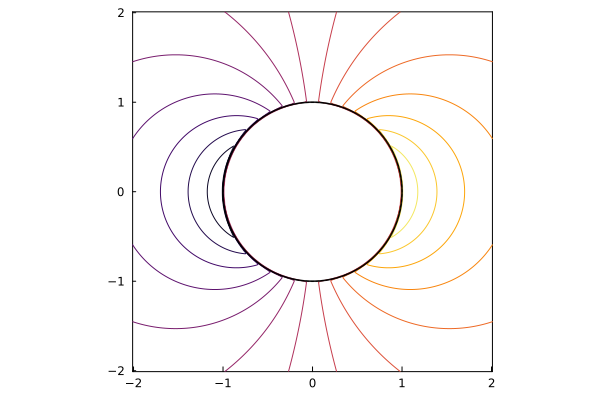

In [7]:
prob = DirichletPoissonProblem(g,body,scaling=GridScaling)
sys = construct_system(prob)

pts = points(sys)
f, s = solve(pts.u,prob,sys)

plot(f,sys)

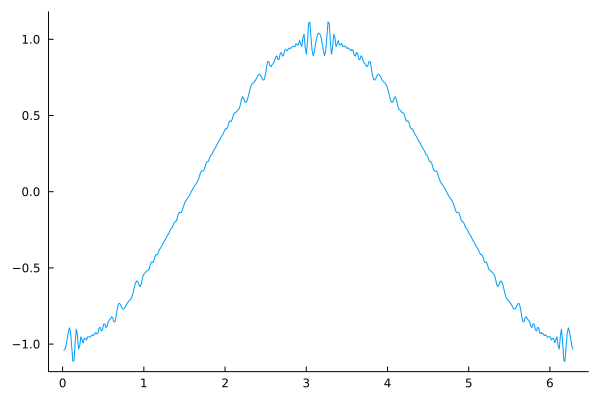

In [8]:
plot(s,sys)

## More advanced use, with keyword arguments
In the previous example, we supplied the surface data as an argument directly to
the `solve` function. We also didn't have any right-hand side forcing. But in
a more general case we might have more complicated boundary conditions or forcing
information. This will be particularly true when we get to time varying problems.

So in this next example, we will demonstrate how the problem constructor can
be used to supply more sophisticated information to the `solve` function.
In particular, we will use three keywords:
* The `bc` keyword to supply boundary condition information.
* The `forcing` keyword to supply forcing.
* The `phys_params` keyword to supply physical parameters.

In general, the philosophy is that we wish to enable the user to provide a function that
supplies the required boundary or forcing data. There is a lot
of freedom in this approach, as we will demonstrate.
### Boundary conditions
Here, we wish to construct functions that return the value of `f`
on the outside and inside of the surface. These functions will
get called in the `solve` function, and they will be passed
the base cache, the physical parameters. So we can make use
of both of these to return the boundary data, e.g., here
we return the `x` coordinate of the surface points on the outside
of the surface, and zeros on the inside.

In [9]:
get_fbplus(base_cache,phys_params) = points(base_cache).u
get_fbminus(base_cache,phys_params) = zeros_surface(base_cache)

get_fbminus (generic function with 1 method)

Using the `bc` keyword, we can pass these along to the problem specification
by various means. To make use of some routines that automate the
application of these functions, we must pass them in a `Dict`, with the
keys `exterior` and `interior`, respectively.

In [10]:
bcdict = Dict("exterior"=>get_fbplus,"interior"=>get_fbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_fbminus
  "exterior" => get_fbplus

### Forcing
Forcing can come in several forms. It can be
* **area forcing**, in which the forcing is distributed over a whole region, possibly confined
* **line forcing**, in which the forcing is distributed along a curve (but singular in the orthogonal direction)
* **point forcing**, in which the forcing is singular at one or more points

In all cases, the user needs to supply some information about the **shape** of the
forcing region and some information about the instantaneous strength of the forcing,
in the form of a **model function**. These get bundled together into a **forcing model**.

For confined area forcing and for line forcing, the **shape** is supplied as a `Body` or `BodyList`,
similar to bodies (serving as the mask for confined-area forcing and as the curve
for line forcing). For point forcing, the **shape** is the set of discrete points
at which we want to apply forcing. We can either supply these points' coordinates directly
or provide them via a **position function** that returns the point coordinates. The advantage
of the latter is that it allows the points to be changed later without
regenerating the system.

In the example shown here, we apply point forcing at two points: one at (-1.0,1.5)
and the other at (1.0,1.5), with respective strengths -1 and 1.
We use a **position function** to provide the positions.
This function must have the signature as shown here, accepting
a general `state` argument, a time argument `t`, the cache for this forcing,
and physical parameters. Any of these can be used to help determine
the point positions. In this case, we just simply provide the coordinates
directly. However, it is straightforward to pass these in via the `state`
argument (or perhaps to update the positions by some velocity).

In [11]:
function my_point_positions(state,t,fr::PointRegionCache,phys_params)
    x = [-1.0,1.0]
    y = [1.5,1.5]
    return x, y
end

my_point_positions (generic function with 1 method)

The **model function** returns the strength of the forcing. In this point
forcing example, it must return the strength of each point. It must be
set up as an in-place function, accepting the vector of strengths and
mutating (i.e. changing) this vector. Beyond that, it has the same
signature as the position function.

In [12]:
function my_point_strengths!(σ,state,t,fr::PointRegionCache,phys_params)
    σ .= [-1.0,1.0]
end

my_point_strengths! (generic function with 1 method)

Now we bundle these together into the forcing model. We also tell
it what kind of regularized DDF we want to use. We use the $M_4'$ DDF here.
`pfm` will get passed into the problem setup via the `forcing` keyword.

In [13]:
pfm = PointForcingModel(my_point_positions,my_point_strengths!;ddftype=CartesianGrids.M4prime);

Now, we need to make sure that the forcing data is used. When
we generate the extra cache, we use the function `ForcingModelAndRegion`
to assemble the forcing's cache.

In [14]:
function ImmersedLayers.prob_cache(prob::DirichletPoissonProblem,base_cache::BasicILMCache)
    @unpack phys_params, forcing = prob
    S = create_RTLinvR(base_cache)
    C = create_surface_filter(base_cache)
    forcing_cache = ForcingModelAndRegion(forcing,base_cache)
    fb = zeros_surface(base_cache)
    fstar = zeros_grid(base_cache)
    DirichletPoissonCache(S,C,forcing_cache,fb,fstar)
end

We now redefine the `solve` function and use the boundary condition and forcing
information. For the forcing, we make use of the function `apply_forcing!`
which takes the forcing and automatically calculates the right-hand side field

In [15]:
function ImmersedLayers.solve(prob::DirichletPoissonProblem,sys::ILMSystem)
    @unpack bc, forcing, phys_params, extra_cache, base_cache = sys
    @unpack gdata_cache = base_cache
    @unpack S, C, forcing_cache, fb, fstar = extra_cache

    f = zeros_grid(base_cache)
    s = zeros_surface(base_cache)

    # apply_forcing! evaluates the forcing field on the grid and put
    # the result in the `gdata_cache`.
    fill!(gdata_cache,0.0)
    apply_forcing!(gdata_cache,f,0.0,forcing_cache,phys_params)

    # Get the prescribed jump in boundary data across the interface using
    # the functions we supplied via the `Dict`.
    prescribed_surface_jump!(fb,sys)

    # Evaluate the double-layer term and add it to the right-hand side
    surface_divergence!(fstar,fb,base_cache)
    fstar .+= gdata_cache

    # Intermediate solution
    inverse_laplacian!(fstar,base_cache)

    # Get the prescribed average of boundary data on the interface using
    # the functions we supplied via the `Dict`.
    prescribed_surface_average!(fb,sys)

    # Correction
    interpolate!(s,fstar,base_cache)
    s .= fb - s
    s .= -(S\s);

    regularize!(f,s,base_cache)
    inverse_laplacian!(f,base_cache)
    f .+= fstar;

    return f, C^6*s
end

### Set up the problem
Now we specify the problem, create the system, and solve it, as before,
but now supplying the boundary condition and forcing information with the `bc`
and `forcing` keywords:

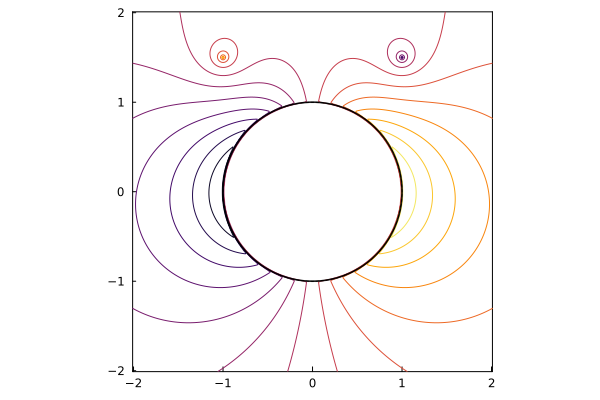

In [16]:
prob = DirichletPoissonProblem(g,body,scaling=GridScaling,bc=bcdict,forcing=pfm)
sys = construct_system(prob)
f, s = solve(prob,sys)
plot(f,sys)

So we get the additional features from the sources. Now, suppose we wish to change the
the boundary conditions or source points? We can do it easily without regenerating the
cache and system, simply by redefining our bc and forcing model functions. For
example, to create an internal solution, with surface data equal to the $y$ coordinate,
and four sources inside.

In [17]:
get_fbplus(base_cache,phys_params) = zeros_surface(base_cache)
get_fbminus(base_cache,phys_params) = points(base_cache).v

function my_point_positions(state,t,fr::PointRegionCache,phys_params)
    x = [-0.2,0.2,-0.2,0.2]
    y = [0.2,0.2,-0.2,-0.2]
    return x, y
end
function my_point_strengths!(σ,state,t,fr::PointRegionCache,phys_params)
    σ .= [-1.0,1.0,-1.0,1.0]
end

my_point_strengths! (generic function with 1 method)

We can solve immediately without having to reconstruct the system, so
it's very fast.

  0.427648 seconds (719.30 k allocations: 66.328 MiB, 92.39% compilation time: 4% of which was recompilation)


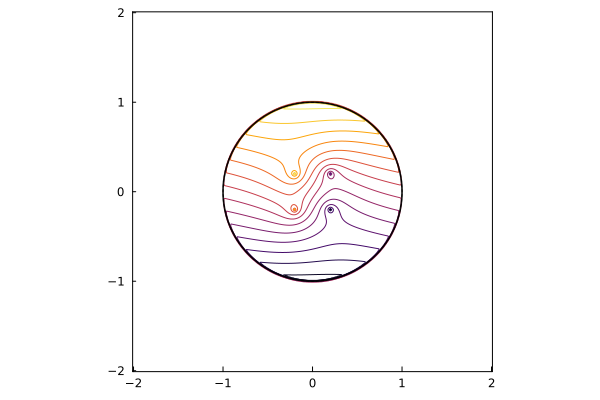

In [18]:
@time f, s = solve(prob,sys)
plot(f,sys)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*